In [1]:
# Data packages
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

from model.utils import get_device, generate_predictions

from data_processing.pipeline import encoding_pipeline, get_generic_name

from model.rnn import GRUDecoder
from model.autoencoder import SimpleAutoEncoder
from model.autoencoder import TabularEncoder

from model.dataset import PretrainingDataset

In [2]:
device = get_device()
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')
importance = pd.read_csv('data/feature_importance/features_importance_xgboost.csv')

Using MPS (Metal Performance Shaders) device


# What is the effect of increasing the number of questions?

## Pretraining
I pretrain on all the data. Currently, I only use the Attn-based autoencoder as it seems to train the fastest.

## Finetuning
We perform 5-fold cross validation for the FT.

### Pretraining

In [3]:
# set parameters for the PT
PT_BATCH_SIZE = 64
PT_HIDDEN_SIZE = 64
PT_ENCODING_SIZE = 64
PT_NUM_HEADS = 3
PT_NUM_LAYERS = 2

PT_num_epochs = 1
PT_learning_rate = 1e-4

n_questions = [50]#, 100, 500, 1000, 5000, 10000]#, 1000, 2000, 4000, 8000, 16000, 27000]
#n_questions = [10000, 5000, 1000, 500, 50]#, 1000, 2000, 4000, 8000, 16000, 27000]
PT_base_model_path = model_name = f"saturation_test_PT_nquestions"

In [4]:
all_train_loss = []   # for plotting
n_cols_list = []

for n_quest in n_questions:
    model_name = PT_base_model_path + '-' + str(n_quest)
    print(model_name)

    custom_pairs = importance.iloc[:n_quest].feature.map(lambda x: get_generic_name(x))
    n_cols = len(set(custom_pairs))
    n_cols_list = n_cols

    print(f'Number of questions: {n_quest}, question pr. year {n_cols_list}')
    
    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
    pretrain_dataset = PretrainingDataset(sequences)

    SEQ_LEN = pretrain_dataset.get_seq_len()
    VOCAB_SIZE = pretrain_dataset.get_vocab_size()
    
    encoder = TabularEncoder(vocab_size=VOCAB_SIZE, embedding_size=PT_HIDDEN_SIZE, output_size=PT_ENCODING_SIZE, 
                             num_heads=PT_NUM_HEADS, num_layers=PT_NUM_LAYERS, sequence_len=SEQ_LEN, 
                             layer_type = "attn", dropout=0.25, decoder_output=3).to(device)
    
    loss_cls = nn.CrossEntropyLoss(label_smoothing=0.01).to(device)
    optimizer = optim.RAdam(encoder.parameters(), lr = PT_learning_rate, weight_decay=1e-3, decoupled_weight_decay=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = PT_num_epochs, eta_min = 1e-5, last_epoch = -1)
    
    train_dataloader = DataLoader(pretrain_dataset, batch_size=PT_BATCH_SIZE, shuffle=True)

    loss_metric = []
    encoder.train()
    for epoch in range(PT_num_epochs):
        loss_epoch_metric = []
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
        for i, (year, seq) in loop_object :
            optimizer.zero_grad()
            year = year.to(device)
            input_seq = seq.to(device)

            seq, targs = generate_predictions(input_seq, vocab_size = VOCAB_SIZE, p = 0.3, missing_token_id=101)
            x = encoder.forward(year = year, seq=seq)

            loss = loss_cls(x.permute(0,2,1), targs.long())
            
            # store loss for plotting
            loss_epoch_metric.append(loss.detach().cpu().numpy())
            all_train_loss.append(loss_epoch_metric[-1])
            n_cols_list.append(n_cols)

            loss.backward()
            optimizer.step()
            loop_object.set_postfix_str("mean loss: %.4f"%np.mean(loss_epoch_metric[-100:]))

        ## After epoch end
        scheduler.step()
        loss_metric.append(np.mean(loss_epoch_metric))
        print(f'epoch {epoch} \t Loss: {loss_metric[-1]:.4g} and LR: {scheduler.get_last_lr()[0]:.5g}')
        
    torch.save(encoder.state_dict(), f'weights/{model_name}_{epoch}.pt')

    print('')

Number of questions: 50, question pr. year 43


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


Embedding Layer with Question Embdeddings


Epochs 0: 0it [00:00, ?it/s]


RuntimeError: shape '[64, 42, 3, 21]' is invalid for input of size 172032

In [25]:
#loss_cls(x.permute(0,2,1), targs.long())
x.permute(0,2,1).shape

torch.Size([96, 3, 205])

In [ ]:
print(128*1980*3*21)
print(16220160)


15966720
16220160


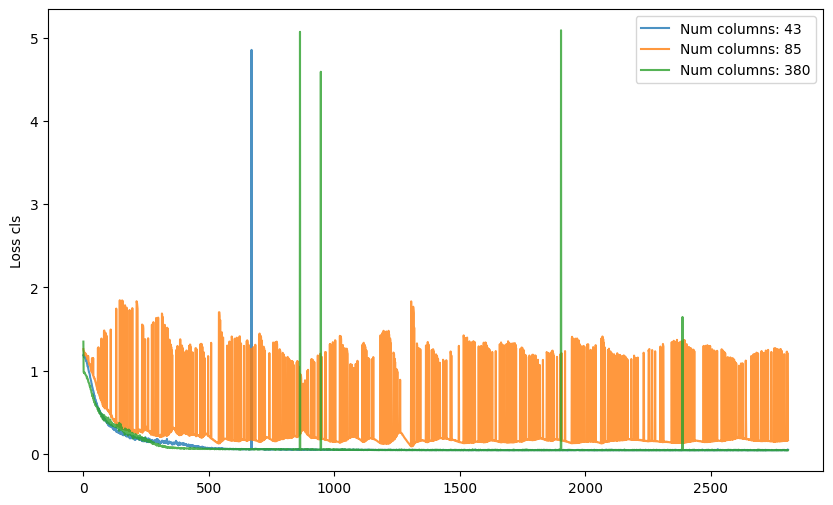

In [ ]:
grouped_data = {}

for i, col in enumerate(n_cols_list):
    if col not in grouped_data:
        grouped_data[col] = []
    grouped_data[col].append(all_train_loss[i])


plt.figure(figsize=(10, 6))

for i, (col, loss_values) in enumerate(grouped_data.items()):
    plt.plot(loss_values, label=f'Num columns: {col}', color = 'C' + str(i), alpha = 0.8)

plt.ylabel('Loss cls')
plt.legend()
plt.show()

### Finetuning


The current setup does not do any cross-validation. Germans seems to have implemented it in train_experimental. Check it out and implement it for the cross-val

In [ ]:
from sklearn.model_selection import StratifiedKFold
from model.dataset import FinetuningDataset

FT_BATCH_SIZE = 16
FT_ENCODING_SIZE = 64
FT_HIDDEN_SIZE = 64
FT_NUM_LAYERS = 2
FT_LEARNING_RATE= 5e-3
FT_NUM_EPOCHS = 3
k_folds = 5

targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
targets = targets[targets.new_child.notna()].reset_index(drop=True)
skf = StratifiedKFold(n_splits=k_folds)

skf.get_n_splits(y=targets['nomem_encr'])

5

In [ ]:
import re
import os

def load_autoencoder(model_name, directory='weights'):
    # Regular expression to match the file format and extract the epoch number
    pattern = re.compile(rf'{model_name}_(\d+)\.pt')
    
    max_epoch = -1
    latest_model_path = None
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        # Check if the filename matches the pattern
        match = pattern.match(filename)
        if match:
            # Extract the epoch number
            epoch = int(match.group(1))
            # Update the latest model path if this epoch is the highest so far
            if epoch > max_epoch:
                max_epoch = epoch
                latest_model_path = os.path.join(directory, filename)
    
    # Load the model from the latest model path
    if latest_model_path:
        model = torch.load(latest_model_path)
        print(f"Loaded model from {latest_model_path}")
        return model
    else:
        raise FileNotFoundError(f"No model files found for {model_name} in {directory}")

In [ ]:
ft_all_train_loss = []
ft_n_cols_list = []


for n_quest in n_questions:
    autoencoder_name = PT_base_model_path + str(n_quest)
    custom_pairs = importance.iloc[:n_quest].feature.map(lambda x: get_generic_name(x))
    n_cols_list = len(set(custom_pairs))
    print(f'Number of questions: {n_quest}, question pr. year {n_cols_list}')
    
    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
    pretrain_dataset = PretrainingDataset(sequences)

    SEQ_LEN = pretrain_dataset.get_seq_len()
    VOCAB_SIZE = pretrain_dataset.get_vocab_size()
    
    # requires that the autoencoders have been trained for given value of n_quest
    encoder = load_autoencoder(model_name=autoencoder_name)
    encoder.eval()

    decoder = GRUDecoder(input_size=FT_ENCODING_SIZE, hidden_size=FT_HIDDEN_SIZE, num_layers=FT_NUM_LAYERS, max_seq_len=14,
                            dropout=0.3, bidirectional=False, with_attention = True).to(device)
    decoder.train()

    # Define loss function and optimizer for RNN
    ft_loss = nn.BCELoss()
    ft_optimizer = torch.optim.NAdam(list(decoder.parameters()), lr=FT_LEARNING_RATE,
                                     weight_decay=1e-2, decoupled_weight_decay=True)
    ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = FT_NUM_EPOCHS,
                                                        eta_min = 1e-6, last_epoch = -1)

    rnn_data = {
        person_id: (
            torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
            torch.tensor([wave_response for _, wave_response in wave_responses.items()]).to(device)
            )
            for person_id, wave_responses in sequences.items()
    }

    train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)
    train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
    test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

    # prepare the data for finetuning
    train_dataset = FinetuningDataset(train_data, targets = targets)
    test_dataset = FinetuningDataset(test_data, targets = targets)

    train_dataloader = DataLoader(train_dataset, batch_size=FT_BATCH_SIZE, shuffle=True)
    test_dataloader  = DataLoader(test_dataset,  batch_size=FT_BATCH_SIZE)
    
    loss_per_epoch = []
    for epoch in range(FT_NUM_EPOCHS):
        # print(epoch)
        loss_per_step = []
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
        for i, batch in loop_object :        
            ft_optimizer.zero_grad() 
            inputs, labels = batch
            labels = labels.to(torch.float).to(device)

            input_year, input_seq = inputs
            bs, ss = labels.size(0), 14
            input_year = input_year.reshape(-1).to(device)
            input_seq = input_seq.reshape(bs * ss, -1).to(device)

            encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
            mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()

            # Forward pass
            outputs = nn.functional.sigmoid(decoder(encodings, mask=mask))

            loss = ft_loss(torch.flatten(outputs), labels)  
            loss_per_step.append(loss.detach().cpu().numpy())
            loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_per_step[-100:]))

            #loss.backward(retain_graph=True)
            loss.backward()
            ft_optimizer.step()
        # On epoch end
        loss_per_epoch.append(np.mean(loss_per_step))
        ft_scheduler.step()

        print(f"Epoch {epoch+1}/{FT_NUM_EPOCHS}, Loss: {loss_per_epoch[-1]:.4f}")

# Old tests

In [ ]:
def finetune(num_epochs_ft, train_dataloader, autoencoder, decoder, ft_loss, ft_optimizer, aggregator, num_cols):
    for epoch in range(num_epochs_ft):
        # print(epoch)
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
        for i, batch in loop_object :        
            ft_optimizer.zero_grad() 
            inputs, labels = batch
            labels = labels.to(torch.float).to(device)

            input_year, input_seq = inputs
            bs, ss = labels.size(0), 14
            input_year = input_year.reshape(-1).to(device)
            input_seq = input_seq.reshape(bs * ss, -1).to(device)

            encodings = autoencoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
            encodings = aggregator(encodings) # make sure that the number of dimensions is aligned after the Simple Decoder
            mask = ~((input_seq == 101).sum(-1) == num_cols).view(bs,ss).detach()

            # Forward pass
            xx = decoder(encodings, mask)
            outputs = F.sigmoid(xx)

            loss = ft_loss(torch.flatten(outputs), labels)  

            #loss.backward(retain_graph=True)
            loss.backward()
            ft_optimizer.step()

In [ ]:
def evaluate(dataloader, encoder, decoder, num_cols, aggregator):
    val_loss = []
    preds = []
    targets = []

    ## Set both models into the eval mode
    decoder.eval()
    encoder.eval()
    for batch in dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        encodings = aggregator(encodings) # make sure that the number of dimensions is aligned after the Simple Decoder
        mask = ~((input_seq == 101).sum(-1) == num_cols).view(bs,ss).detach()

        # Forward pass
        xx = decoder(encodings, mask)
        outputs = torch.nn.functional.sigmoid(xx).flatten()
        loss = ft_loss(outputs, labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(outputs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())


    # Concatenate all the batches
    predictions = (torch.tensor(preds) > 0.5).float()
    probs = F.sigmoid(predictions)
    actuals = torch.tensor(targets).flatten()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
    map_roc = average_precision_score(actuals.numpy(), probs.numpy())
    
    return precision, recall, f1, map_roc

In [ ]:
PT_HIDDEN_DIM=128
PT_BATCH_SIZE=128
PT_NUM_EPOCHS=5
PT_LEARNING_RATE=10e-2

FT_BATCH_SIZE = 16
FT_ENCODING_SIZE = 64
FT_HIDDEN_SIZE = 64

FT_NUM_EPOCHS = 3
FT_LEARNING_RATE= 5e-3
n_questions = [50, 100, 200, 500]#, 1000, 2000, 4000, 8000, 16000, 27000]
reps = 1

targets = targets[targets.new_child.notna()].reset_index(drop=True)

In [ ]:
prec_list = []
rec_list = []
f1_list = []
train_prec_list = []
train_rec_list = []
train_f1_list = []

n_question_list = []
n_col_list = []

train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)

for n_question in n_questions:
    print(n_question)
    custom_pairs = importance.iloc[:n_question].feature.map(lambda x: get_generic_name(x))

    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
    pretrain_dataset = PretrainingDataset(sequences)
    
    SEQ_LEN = pretrain_dataset.get_seq_len()
    vocab_size = pretrain_dataset.get_vocab_size()

    pt_dataloader = DataLoader(pretrain_dataset, batch_size=PT_BATCH_SIZE, shuffle=True)

    for rep in range(reps):

        # initialize autoencoder and pretrain    
        autoencoder = SimpleAutoEncoder(vocab_size=vocab_size, embedding_size=PT_HIDDEN_DIM, sequence_len=SEQ_LEN).to(device)
        autoencoder.train()
        autoencoder.to(device)

        pt_loss_cls = nn.CrossEntropyLoss()
        pt_optimizer = optim.RAdam(autoencoder.parameters(), lr = PT_LEARNING_RATE, weight_decay=1e-2, decoupled_weight_decay=True)
        pt_scheduler = optim.lr_scheduler.CosineAnnealingLR(pt_optimizer, T_max = PT_NUM_EPOCHS, eta_min = 1e-5, last_epoch = -1)

        autoencoder.train()
        pretrain(pt_epochs=PT_NUM_EPOCHS,
            train_dataloader=pt_dataloader,
            autoencoder=autoencoder,
            loss_pt=pt_loss_cls,
            optimizer_pt=pt_optimizer,
            scheduler_pt=pt_scheduler,
            )
        autoencoder.eval()

        # initialize GRU and perform fine-tuning    

        rnn_data = {
            person_id: (
                torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
                torch.tensor([wave_response for _, wave_response in wave_responses.items()]).to(device)
                )
                for person_id, wave_responses in sequences.items()
        }

        train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
        test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

        train_dataset = FinetuningDataset(train_data, targets = targets)
        test_dataset = FinetuningDataset(test_data, targets = targets)

        train_dataloader = DataLoader(train_dataset, batch_size=FT_BATCH_SIZE, shuffle=True)
        test_dataloader  = DataLoader(test_dataset,  batch_size=FT_BATCH_SIZE)

        aggregator = nn.Sequential(
            nn.LazyInstanceNorm1d(),
            nn.LazyLinear(FT_ENCODING_SIZE),
            nn.LazyBatchNorm1d()).to(device)

        decoder = GRUDecoder(
            input_size=FT_ENCODING_SIZE,
            hidden_size=FT_HIDDEN_SIZE,
            max_seq_len=14,
            dropout=0.15,
            bidirectional= False, 
            num_layers=2,
            with_attention= True
        ).to(device)

        # Define loss function and optimizer for RNN
        ft_loss = torch.nn.BCELoss()
        ft_optimizer = torch.optim.RAdam(list(decoder.parameters()) + list(autoencoder.parameters()) + list(aggregator.parameters()) , 
                                                                           lr=FT_LEARNING_RATE, 
                                                                           weight_decay=1e-3, 
                                                                           decoupled_weight_decay=True)
        ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = FT_NUM_EPOCHS, eta_min = 1e-6, last_epoch = -1)

        # Training loop
        decoder.train()
        aggregator.train()
        
        NUM_COLS = next(iter(train_dataloader))[0][1].shape[-1]
        finetune(
            num_epochs_ft=FT_NUM_EPOCHS,
            train_dataloader=train_dataloader,
            autoencoder=autoencoder,
            ft_loss=ft_loss,
            ft_optimizer=ft_optimizer,
            decoder=decoder,
            aggregator=aggregator,
            num_cols=NUM_COLS
        )
        
        precision, recall, f1, map_roc = evaluate(dataloader=test_dataloader,
                                                encoder=autoencoder,
                                                decoder=decoder,
                                                num_cols=NUM_COLS,
                                                aggregator=aggregator)
        precision_train, recall_train, f1_train, map_roc_train = evaluate(dataloader=train_dataloader,
                                                                          encoder=autoencoder,
                                                                          decoder=decoder,
                                                                          num_cols=NUM_COLS,
                                                                          aggregator=aggregator
                                                                          )
        
        prec_list.append(precision)
        rec_list.append(recall)
        f1_list.append(f1)

        train_prec_list.append(precision_train)
        train_rec_list.append(recall_train)
        train_f1_list.append(f1_train)
        
        n_question_list.append(n_question)
        n_col_list.append(NUM_COLS)

50


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


check


Epochs 0: 702it [00:25, 27.53it/s]
Epochs 1: 702it [00:23, 30.35it/s]
Epochs 2: 702it [00:22, 31.45it/s]
Epochs 3: 702it [00:22, 31.17it/s]
Epochs 4: 702it [00:22, 30.70it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:05,  9.00it/s]
Epochs 1: 50it [00:05,  9.38it/s]
Epochs 2: 50it [00:05,  9.48it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: Undefine

100
check


Epochs 0: 702it [01:06, 10.58it/s]
Epochs 1: 702it [00:58, 12.06it/s]
Epochs 2: 702it [00:49, 14.11it/s]
Epochs 3: 702it [00:47, 14.67it/s]
Epochs 4: 702it [00:49, 14.04it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:10,  4.79it/s]
Epochs 1: 50it [00:09,  5.42it/s]
Epochs 2: 50it [00:09,  5.34it/s]


200


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


check


Epochs 0: 702it [02:22,  4.91it/s]
Epochs 1: 702it [02:04,  5.66it/s]
Epochs 2: 702it [01:43,  6.78it/s]
Epochs 3: 702it [01:31,  7.65it/s]
Epochs 4: 702it [01:37,  7.22it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:16,  3.11it/s]
Epochs 1: 50it [00:15,  3.32it/s]
Epochs 2: 50it [00:14,  3.39it/s]


500


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


check


Epochs 0: 702it [05:51,  2.00it/s]
Epochs 1: 702it [04:12,  2.78it/s]
Epochs 2: 702it [04:10,  2.80it/s]
Epochs 3: 702it [31:34,  2.70s/it] 
Epochs 4: 702it [06:13,  1.88it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:33,  1.47it/s]
Epochs 1: 50it [00:32,  1.53it/s]
Epochs 2: 50it [00:33,  1.50it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: Undefin

In [ ]:
results = pd.DataFrame({
    'Precision_test': prec_list,
    'Recall_test': rec_list,
    'f1_test': f1_list,
    'Precision_train': train_prec_list,
    'Recall_train': train_rec_list,
    'f1_train': train_f1_list,
    'n_questions': n_question_list
    })
#results.to_csv('saturation_results.csv')

In [ ]:
results

,Precision_test,Recall_test,f1_test,Precision_train,Recall_train,f1_train,n_questions
0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,50
1,0.75,0.18,0.290323,0.852459,0.320988,0.466368,100
2,0.60,0.18,0.276923,0.771930,0.271605,0.401826,200
3,0.00,0.00,0.000000,0.000000,0.000000,0.000000,500


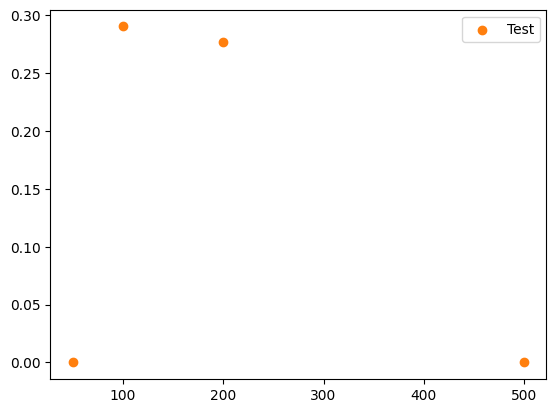

In [ ]:
fig, ax = plt.subplots()
#ax.scatter(results['n_questions'], results['f1_train'], color='C0', label='Train')
ax.scatter(results['n_questions'], results['f1_test'], color='C1', label='Test')
#plt.yscale('log')
plt.legend()
plt.show()

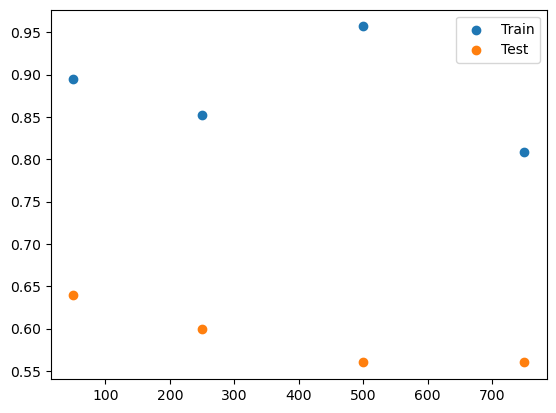

In [ ]:

fig, ax = plt.subplots()
ax.scatter(results['n_questions'], results['Recall_train'], color='C0', label='Train')
ax.scatter(results['n_questions'], results['Recall_test'], color='C1', label='Test')
plt.legend()
plt.show()

In [ ]:

batch = next(iter(train_dataloader))        

inputs, labels = batch

input_year, input_seq = inputs
bs, ss = labels.size(0), 14
print(input_seq.shape)
input_seq = input_seq.reshape(bs * ss, -1)

print(input_seq.shape)


torch.Size([16, 14, 385])
torch.Size([224, 385])


In [ ]:
next(iter(train_dataloader))[0][1].shape[-1]


385